# 3 EDA, Preprocessing and Training<a id='3_EDA_Preprocessing_and_Training'></a>

## 3.1 Imports<a id='3.1_Imports'></a>

In [1]:
import pandas as pd
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import __version__ as sklearn_version
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, learning_curve, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.metrics import classification_report,confusion_matrix,roc_curve,roc_auc_score
from sklearn.metrics import accuracy_score,log_loss
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import datetime
import lightgbm
from bayes_opt import BayesianOptimization

## 3.2 Load Data<a id='3.2_Load_Data'></a>

In [2]:
# function to reduce memory(transaction data takes more 1.7GB of memory)
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage(deep=True).sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                c_prec = df[col].apply(lambda x: np.finfo(x).precision).max()
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max and c_prec == np.finfo(np.float32).precision:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage(deep=True).sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [3]:
iee_data = pd.read_csv('/df_cleaned.csv')

In [4]:
iee_data = reduce_mem_usage(iee_data)

Mem. usage decreased to 2645.85 Mb (1.5% reduction)


In [5]:
iee_data.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 590540 entries, 0 to 590539
Data columns (total 434 columns):
 #    Column                     Non-Null Count   Dtype  
---   ------                     --------------   -----  
 0    TransactionID              590540 non-null  int32  
 1    isFraud                    590540 non-null  int8   
 2    TransactionDT              590540 non-null  object 
 3    TransactionAmt             590540 non-null  float64
 4    ProductCD                  590540 non-null  object 
 5    card1                      590540 non-null  int16  
 6    card2                      581607 non-null  float64
 7    card3                      588975 non-null  float64
 8    card4                      588963 non-null  object 
 9    card5                      586281 non-null  float64
 10   card6                      588969 non-null  object 
 11   addr1                      524834 non-null  float64
 12   addr2                      524834 non-null  float64
 13   dist1       

In [6]:
# check a few rows from the data
iee_data.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,TransactionDT_Month,TransactionDT_Day,TransactionDT_Year,TransactionDT_Week Number,TransactionDT_Day Of Week,TransactionDT_Day Name,TransactionDT_Month Name,TransactionDT_Hour,TransactionDT_Minute,TransactionDT_Second
0,2987000,0,2017-12-02 00:00:00,68.5,W,13926,NaN,150.0,discover,142.0,...,12,2,2017,48,5,Saturday,December,0,0,0
1,2987001,0,2017-12-02 00:00:01,29.0,W,2755,404.0,150.0,mastercard,102.0,...,12,2,2017,48,5,Saturday,December,0,0,1
2,2987002,0,2017-12-02 00:01:09,59.0,W,4663,490.0,150.0,visa,166.0,...,12,2,2017,48,5,Saturday,December,0,1,9
3,2987003,0,2017-12-02 00:01:39,50.0,W,18132,567.0,150.0,mastercard,117.0,...,12,2,2017,48,5,Saturday,December,0,1,39
4,2987004,0,2017-12-02 00:01:46,50.0,H,4497,514.0,150.0,mastercard,102.0,...,12,2,2017,48,5,Saturday,December,0,1,46


## 3.3 Exploratory Data Analysis<a id='3.3_Exploratory_Data_Analysis'></a>

#### 3.3.1 Transaction Amount By Card Company<a id='3.3.1_Transaction_Amount_By_Card_Company'></a>

In [7]:
amnt_by_card = iee_data.groupby('card4')['TransactionAmt'].mean()

In [8]:
amnt_by_card.sort_values(ascending=False)

card4
discover            265.750425
american express    173.057137
visa                133.161806
mastercard          132.387731
Name: TransactionAmt, dtype: float64

The average transaction amount by card company with discover being the most cards used by customers for transactions

In [9]:
# What is the mean of transactions, for fraud cases only, to each card type
iee_data[iee_data['isFraud']==1].groupby('card4')['TransactionAmt'].mean()

card4
american express    179.071900
discover            354.086459
mastercard          131.733248
visa                149.383523
Name: TransactionAmt, dtype: float64

#### 3.3.2 Percent of fraud related cases by card type<a id='3.3.2_Percent_of_fraud_related_cases_by_card_type'></a>

In [10]:
fraud_by_card = iee_data.groupby(['card4','isFraud']).size().unstack()

In [11]:
fraud_by_card = fraud_by_card.div(fraud_by_card.sum(1),axis=0)
fraud_by_card

isFraud,0,1
card4,,
american express,0.971302,0.028698
discover,0.922718,0.077282
mastercard,0.965669,0.034331
visa,0.965244,0.034756


<AxesSubplot:title={'center':'Is Fraud by Card Company'}, ylabel='card4'>

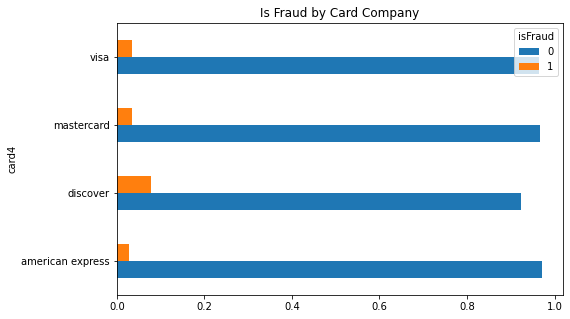

In [12]:
fig,ax = plt.subplots(1,1,figsize=(8,5))
fraud_by_card.plot(ax=ax,kind='barh',title='Is Fraud by Card Company')

Among the four card providers, `discover` appears to be the one most associated with fraud ransactions with a percentage of approximately 7.73%. `Visa` and `mastercard` followed next with a percentage of aproximately 3.5% and 3.43% respectively

#### 3.3.3 Devices used for Fraud transactions<a id='3.3.3_Devices_used_for_Fraud_transactions'></a>

In [13]:
fraud_by_device = iee_data.groupby(['DeviceType','isFraud']).size().unstack()
fraud_by_device = fraud_by_device.div(fraud_by_device.sum(1),axis=0)
fraud_by_device

isFraud,0,1
DeviceType,,
desktop,0.934785,0.065215
mobile,0.898338,0.101662


<AxesSubplot:title={'center':'Is Fraud by Device Type'}, ylabel='DeviceType'>

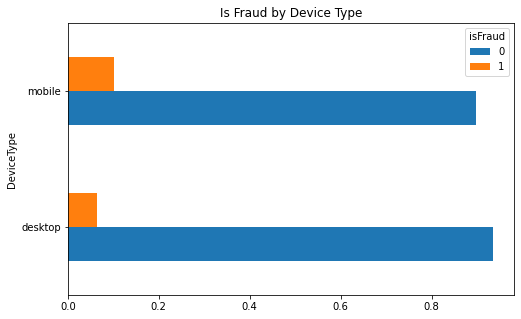

In [14]:
fig,ax = plt.subplots(1,1,figsize=(8,5))
fraud_by_device.plot(ax=ax,kind='barh',title='Is Fraud by Device Type')

Mobile devices accounted for most fraud transactions related averaging 10% with desktop devices averaging 6.5%

#### 3.3.4 Count of Fraud by Day and Month<a id='3.3.4_Count_of_Fraud_by_Day_and_Month'></a>

In [15]:
iee_data.groupby(['TransactionDT_Day Name', 'isFraud']).size().unstack()

isFraud,0,1
TransactionDT_Day Name,,
Friday,83166,3211
Monday,67720,2503
Saturday,94952,3550
Sunday,76871,2963
Thursday,82410,2946
Tuesday,82746,2687
Wednesday,82012,2803


In [16]:
iee_data.groupby(['TransactionDT_Month Name', 'isFraud']).size().unstack()

isFraud,0,1
TransactionDT_Month Name,,
April,80721,2850
December,130938,3401
February,82245,3480
January,88821,3689
June,2635,119
March,97938,4030
May,86579,3094


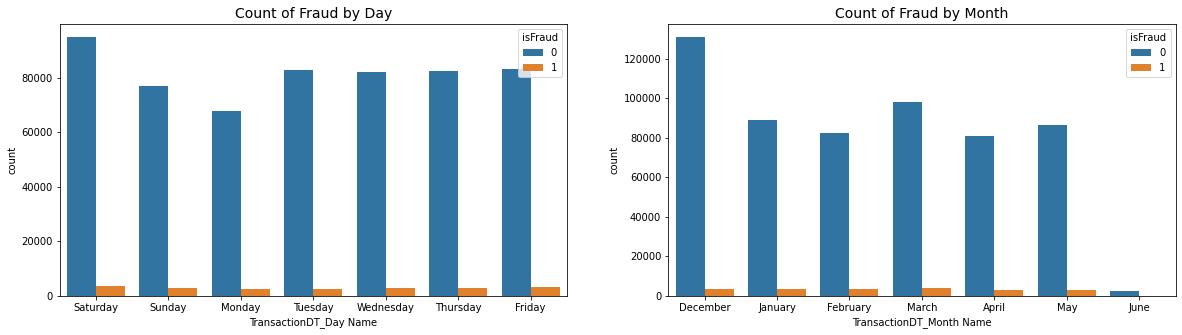

In [17]:
fig, ax = plt.subplots(1, 2, figsize=(20,5))

sns.countplot(x="TransactionDT_Day Name", ax=ax[0], hue = 'isFraud', data=iee_data)
ax[0].set_title('Count of Fraud by Day', fontsize=14)
sns.countplot(x="TransactionDT_Month Name", ax=ax[1], hue= 'isFraud', data=iee_data)
ax[1].set_title('Count of Fraud by Month', fontsize=14)
plt.show()

In [18]:
iee_data['TransactionDT'] = iee_data['TransactionDT'].apply(pd.to_datetime)

In [19]:
by_fraud = iee_data[iee_data['isFraud']==1]

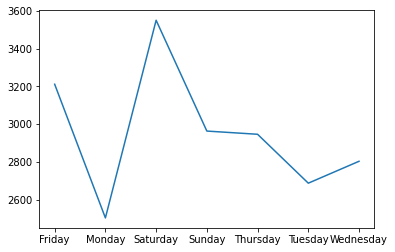

In [20]:
plt.plot(by_fraud.groupby('TransactionDT_Day Name')['TransactionDT'].count())

From the above table and graph, it can be noted that most fraud transactions were done in `March` and `Saturday` with 4030 and 3550 transactions respectively

#### 3.3.5 Count of Fraud by Product<a id='3.3.5_Count_of_Fraud_by_Product'></a>

In [21]:
iee_data.groupby(['ProductCD', 'isFraud']).size().unstack()

isFraud,0,1
ProductCD,,
C,60511,8008
H,31450,1574
R,36273,1426
S,10942,686
W,430701,8969


Text(0.5, 1.0, 'Count of Fraud by Product')

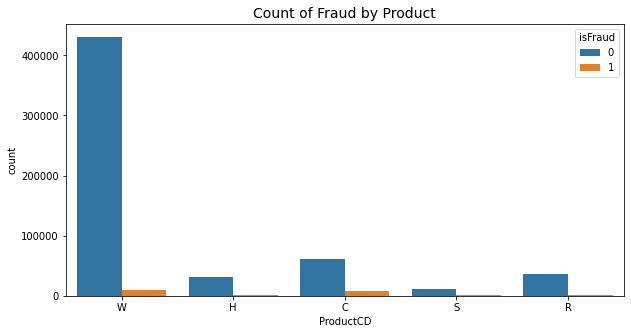

In [22]:
plt.figure(figsize=(10,5))

sns.countplot(x='ProductCD', hue = 'isFraud', data=iee_data)
plt.title('Count of Fraud by Product', fontsize=14)

Really don't know much about these product types `W` had the most related fraud cases accounting about 8969 of the total fraud transactions

#### 3.3.6 Which day had the most average Fraud Transaction Amount?<a id='3.3.6_Which_day_had_the_most_average_Fraud_by_Transaction_Amount'></a>

In [23]:
iee_data.groupby('isFraud')['TransactionAmt'].mean()

isFraud
0    134.511665
1    149.244779
Name: TransactionAmt, dtype: float64

In [24]:
iee_data[iee_data['isFraud']==1].groupby('TransactionDT_Day Name')['TransactionAmt'].mean()

TransactionDT_Day Name
Friday       144.361011
Monday       137.160273
Saturday     147.873404
Sunday       141.037349
Thursday     165.779017
Tuesday      156.807161
Wednesday    151.416132
Name: TransactionAmt, dtype: float64

Transaction amount detected fraud was on `Thursday` with an average transaction amount of about $165.78

#### 3.3.7 Fraud transactions by the hour<a id='3.3.7_Fraud_transactions_by_the_hour'></a>

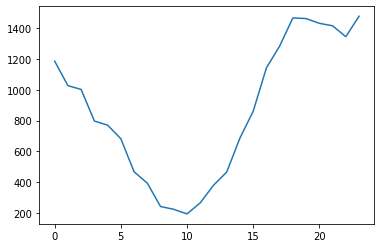

In [25]:
plt.plot(by_fraud.groupby('TransactionDT_Hour')['TransactionDT'].count())

Most fraud transactions occur within the hours of midday to midnight and drops in the mornings.

#### 3.3.8 Distribution of Transaction Amount<a id='3.3.8_Distribution_of_Transaction_Amount'></a>

<AxesSubplot:xlabel='TransactionAmt', ylabel='Count'>

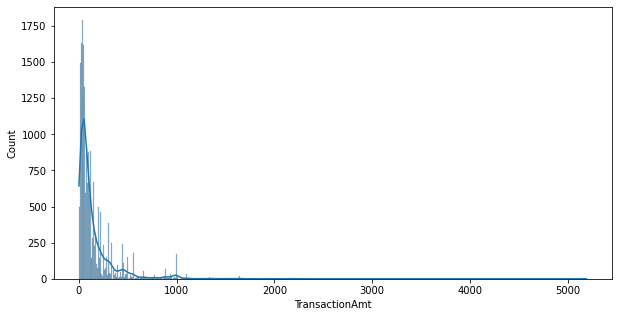

In [26]:
plt.figure(figsize=(10,5))
sns.histplot(data=by_fraud, x='TransactionAmt', kde=True)

#### 3.3.9 Distribution of target variable isFraud<a id='3.3.9_Distribution_of_target_variable_isFraud'></a>

<AxesSubplot:xlabel='isFraud', ylabel='count'>

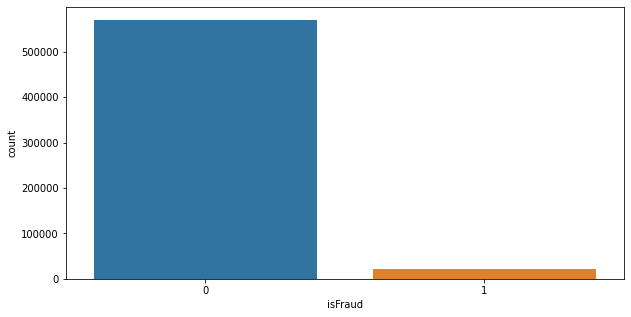

In [27]:
plt.figure(figsize=(10,5))
sns.countplot(x='isFraud', data=iee_data)

We see an imbalanced data in terms of the target variable. The negatives are more than the positives and this needs to be accounted for in the final analysis

In [60]:
# distribution report for all features
#report = iee_data.profile_report(sort='None', html={'style':{'full_width': True}}, progress_bar=False)
#report

## 3.4 Preprocessing and Training<a id='3.5_Preprocessing_and_Training'></a>

In [28]:
# make a copy of the dataframe
df = iee_data.copy()

In [29]:
# inspect the data types of the features
df.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 590540 entries, 0 to 590539
Data columns (total 434 columns):
 #    Column                     Non-Null Count   Dtype         
---   ------                     --------------   -----         
 0    TransactionID              590540 non-null  int32         
 1    isFraud                    590540 non-null  int8          
 2    TransactionDT              590540 non-null  datetime64[ns]
 3    TransactionAmt             590540 non-null  float64       
 4    ProductCD                  590540 non-null  object        
 5    card1                      590540 non-null  int16         
 6    card2                      581607 non-null  float64       
 7    card3                      588975 non-null  float64       
 8    card4                      588963 non-null  object        
 9    card5                      586281 non-null  float64       
 10   card6                      588969 non-null  object        
 11   addr1                      524834 non

In [30]:
# columns to drop
cols = ['TransactionID', 'TransactionDT', 'P_emaildomain', 'R_emaildomain', 'R_emaildomain_bin', 'DeviceInfo', 'card6',
           'id_33', 'id_34', 'id_31', 'id_30', 'TransactionDT_Month Name', 'TransactionDT_Day Name', 'TransactionDT_Year',
               'TransactionDT_Day Of Week']
df.drop(columns=cols, axis=1, inplace=True)

In [31]:
# function to calculate missing values by columns
def missing_values_pct(df):
    pd.options.display.max_rows = 100 # number of rows to print since we have more columns
    missing = pd.concat([df.isnull().sum(), 100 * df.isnull().mean()], axis=1)
    missing.columns = ['count', '%']
    sorted_ms = missing.sort_values(by='%', ascending=False).head(100)
    return sorted_ms

In [32]:
missing_values_pct(df)

,count,%
D13,528588,89.509263
D14,528353,89.469469
D12,525823,89.041047
id_04,524216,88.768923
id_03,524216,88.768923
D6,517353,87.606767
D9,515614,87.312290
D8,515614,87.312290
id_09,515614,87.312290
id_10,515614,87.312290


Some features has more than 80% missing values

In [38]:
# Drop columns with missing values using a threshold
# Drop any column with more than 70% missing values
#threshold = len(df) * 0.30
#df = df.dropna(thresh=threshold, axis=1)

In [39]:
#missing_values_pct(df)

In [40]:
#df.dtypes.to_dict()

In [33]:
# fillna for numeric columns
df.fillna(df.select_dtypes(include='number').median().iloc[0], inplace=True)

# fillna for categorical columns
df.fillna(df.select_dtypes(include='object').mode().iloc[0], inplace=True)

In [34]:
# check for missing values in each column
missing_values_pct(df)

,count,%
isFraud,0,0.0
V267,0,0.0
V239,0,0.0
V238,0,0.0
V237,0,0.0
V236,0,0.0
V235,0,0.0
V234,0,0.0
V233,0,0.0
V232,0,0.0


### 3.4.1 Train/Test Split<a id='3.4.1_Train/Test_Split'></a>

In [35]:
# target and features
X = df.drop(columns=['isFraud'], axis=1)
y = df['isFraud']

# create dummy features for X
X = pd.get_dummies(X, drop_first=True)

In [36]:
# split to train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [37]:
# split the train set further to train and validation sets
x_train, x_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

In [38]:
# check the shape of each new dataset created
print("Shape of x_train:",x_train.shape)
print("Shape of X_test:",X_test.shape)
print("Shape of x_val:",x_val.shape)
print("Shape of y_train:",y_train.shape)
print("Shape of y_test:",y_test.shape)
print("Shape of y_val:",y_val.shape)

Shape of x_train: (332178, 453)
Shape of X_test: (147635, 453)
Shape of x_val: (110727, 453)
Shape of y_train: (332178,)
Shape of y_test: (147635,)
Shape of y_val: (110727,)


### 3.5 ML Models<a id='3.5_ML_Models'></a>

#### 3.5.1 RandomForest Classifier<a id='3.5.1_RandomForest_Classifier'></a>

In [39]:
# instantiate RandomForestClassifier
rf_clf = RandomForestClassifier(n_estimators=500, max_depth=8, min_samples_split=2, random_state=42)

# fit to the training set
rf_clf.fit(x_train, y_train)

# predict on the test set
y_pred_rf = rf_clf.predict(X_test)

# check accuracy score
print(accuracy_score(y_pred_rf, y_test))

0.971659836759576


Accuracy = 0.97
Recall = 0.23



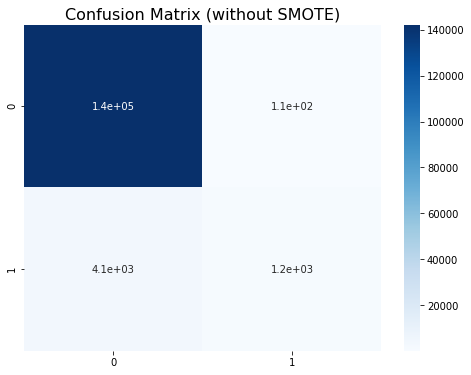

In [44]:
from sklearn.metrics import confusion_matrix,recall_score
print(f'Accuracy = {accuracy_score(y_test, y_pred_rf):.2f}\nRecall = {recall_score(y_test, y_pred_rf):.2f}\n')
cm = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(8, 6))
plt.title('Confusion Matrix (without SMOTE)', size=16)
sns.heatmap(cm, annot=True, cmap='Blues');

#### 3.5.2 XGBoost Classier<a id='3.5.2_XGBoost_Classifier'></a>

In [45]:
# instantiate the XGBClassifier
xg_boost = XGBClassifier(random_state=42, n_estimators=50, learning_rate=0.05)

# fit to the train set
xg_model = xg_boost.fit(x_train, y_train)

# predict on the test set
y_pred_xg = xg_model.predict(X_test)

# check for accuracy
print(accuracy_score(y_pred_xg, y_test))

0.9705964032919023


Accuracy = 0.97
Recall = 0.21



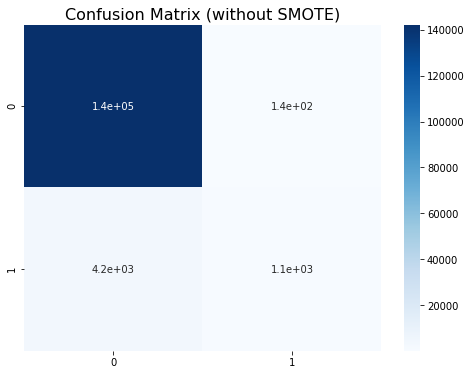

In [46]:
from sklearn.metrics import confusion_matrix,recall_score
print(f'Accuracy = {accuracy_score(y_test, y_pred_xg):.2f}\nRecall = {recall_score(y_test, y_pred_xg):.2f}\n')
cm = confusion_matrix(y_test, y_pred_xg)
plt.figure(figsize=(8, 6))
plt.title('Confusion Matrix (without SMOTE)', size=16)
sns.heatmap(cm, annot=True, cmap='Blues');

#### 3.5.3 Deep Learning Keras Model<a id='3.5.3_Deep_Learning_Keras_Model'></a>

In [47]:
from keras.models import Sequential
from keras.layers import Dense
from keras.utils.np_utils import to_categorical

In [48]:
# convert x_train, x_val and X_test to matrix
x_train = x_train.values
x_val = x_val.values
X_test = X_test.values

In [49]:
#Design the deep neural network [Small + 1 layer]
model  = Sequential()
model.add(Dense(256,input_dim = x_train.shape[1],activation="relu"))
model.add(Dense(1,activation = "sigmoid")) #activation = sigmoid for binary classification
model.compile(optimizer = "Adam",loss="binary_crossentropy", metrics=["accuracy"])
model.fit(x_train,y_train, validation_data = (x_val,y_val),epochs=10, batch_size=64)

Epoch 1/10
5191/5191 [==============================] - 11s 2ms/step - loss: 36.0514 - accuracy: 0.9405 - val_loss: 27.8420 - val_accuracy: 0.9664
Epoch 2/10
5191/5191 [==============================] - 8s 2ms/step - loss: 16.5808 - accuracy: 0.9466 - val_loss: 4.5775 - val_accuracy: 0.9055
Epoch 3/10
5191/5191 [==============================] - 8s 2ms/step - loss: 9.1843 - accuracy: 0.9522 - val_loss: 7.5525 - val_accuracy: 0.9661
Epoch 4/10
5191/5191 [==============================] - 9s 2ms/step - loss: 3.4144 - accuracy: 0.9580 - val_loss: 0.4370 - val_accuracy: 0.9690
Epoch 5/10
5191/5191 [==============================] - 9s 2ms/step - loss: 0.4658 - accuracy: 0.9625 - val_loss: 0.1986 - val_accuracy: 0.9650
Epoch 6/10
5191/5191 [==============================] - 9s 2ms/step - loss: 0.1406 - accuracy: 0.9655 - val_loss: 0.1377 - val_accuracy: 0.9651
Epoch 7/10
5191/5191 [==============================] - 11s 2ms/step - loss: 0.1458 - accuracy: 0.9653 - val_loss: 0.1957 - val_accu

In [50]:
# evaluate the model on the test set
result = model.evaluate(X_test,y_test)

for i in range(len(model.metrics_names)):
    print("Metric ",model.metrics_names[i],":",str(round(result[i],2)))

4614/4614 [==============================] - 4s 768us/step - loss: 0.1307 - accuracy: 0.9641
Metric  loss : 0.13
Metric  accuracy : 0.96


The overall accuracy after 10 epochs is 96.54% and the validation accuracy is 96.99%. The accuracy on the test set is about 96%

In [51]:
#Design the deep neural network [Small + 2 layers]
model2  = Sequential()
model2.add(Dense(256,input_dim = x_train.shape[1],activation="relu"))
model2.add(Dense(256,activation="relu"))
model2.add(Dense(1,activation = "sigmoid"))
model2.compile(optimizer = "Adam",loss="binary_crossentropy", metrics=["accuracy"])
history = model2.fit(x_train,y_train, validation_data = (x_val,y_val), epochs=10, batch_size=64)

Epoch 1/10
5191/5191 [==============================] - 12s 2ms/step - loss: 48.0872 - accuracy: 0.9418 - val_loss: 0.3963 - val_accuracy: 0.9659
Epoch 2/10
5191/5191 [==============================] - 11s 2ms/step - loss: 0.3766 - accuracy: 0.9632 - val_loss: 0.1903 - val_accuracy: 0.9653
Epoch 3/10
5191/5191 [==============================] - 11s 2ms/step - loss: 0.1672 - accuracy: 0.9648 - val_loss: 0.1663 - val_accuracy: 0.9651
Epoch 4/10
5191/5191 [==============================] - 11s 2ms/step - loss: 0.1906 - accuracy: 0.9649 - val_loss: 0.1807 - val_accuracy: 0.9651
Epoch 5/10
5191/5191 [==============================] - 11s 2ms/step - loss: 0.1675 - accuracy: 0.9652 - val_loss: 0.1404 - val_accuracy: 0.9650
Epoch 6/10
5191/5191 [==============================] - 11s 2ms/step - loss: 0.1639 - accuracy: 0.9650 - val_loss: 0.2864 - val_accuracy: 0.9651
Epoch 7/10
5191/5191 [==============================] - 11s 2ms/step - loss: 0.1434 - accuracy: 0.9656 - val_loss: 0.1384 - val_a

In [52]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 256)               116224    
_________________________________________________________________
dense_3 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 257       
Total params: 182,273
Trainable params: 182,273
Non-trainable params: 0
_________________________________________________________________


In [53]:
# evaluate the model on the test set
result = model2.evaluate(X_test,y_test)

for i in range(len(model2.metrics_names)):
    print("Metric ",model2.metrics_names[i],":",str(round(result[i],2)))

4614/4614 [==============================] - 4s 857us/step - loss: 0.1460 - accuracy: 0.9640
Metric  loss : 0.15
Metric  accuracy : 0.96


We see an a slight improvement in the overall accuracy and the validation accuracy with 96.58% for training. The test score didn't change, with the same 96% accuracy.

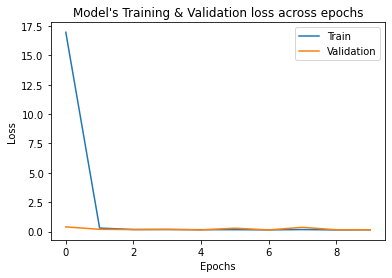

In [54]:
# Model's Training & Validation loss across epochs
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Model's Training & Validation loss across epochs")
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

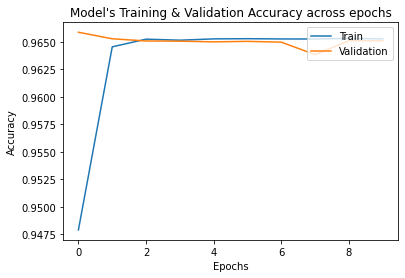

In [55]:
# Model's Training & Validation Accuracy across epochs
plt.plot(history.history['accuracy']) 
plt.plot(history.history['val_accuracy'])
plt.title("Model's Training & Validation Accuracy across epochs") 
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Train', 'Validation'], loc='upper right') 
plt.show()

#### 3.6 SMOTE for Imbalanced target variable<a id='3.6_SMOTE_for_Imbalanced_target_variable'></a>

In [56]:
# applying SMOTE to make sure the model is not overfitting
from imblearn.over_sampling import SMOTE 

sm = SMOTE(random_state=42)

X_sm, y_sm = sm.fit_resample(X, y)

print(f'''Shape of X before SMOTE: {X.shape}
Shape of X after SMOTE: {X_sm.shape}''')

print('\nBalance of positive and negative classes (%):')
y_sm.value_counts(normalize=True) * 100

Shape of X before SMOTE: (590540, 453)
Shape of X after SMOTE: (1139754, 453)

Balance of positive and negative classes (%):


0    50.0
1    50.0
Name: isFraud, dtype: float64

In [57]:
# scale training and test set
scaler = StandardScaler()
scaler.fit(X_sm)
X_scaled_sm = scaler.transform(X_sm)

In [58]:
# split to train and test sets
X_train_sm, X_test_sm, y_train_sm, y_test_sm = train_test_split(
    X_scaled_sm, y_sm, test_size=0.25, random_state=42
)

In [60]:
# further split to train and validation sets
x_train_sm, x_val_sm, y_train_sm, y_val_sm = train_test_split(
    X_train_sm, y_train_sm, test_size=0.25, random_state=42
)

#### 3.6.1 RandomForest Classifier<a id='3.6.1_RandomForest_Classifier'></a>

0.9065554381815055
Accuracy = 0.91
Recall = 0.87



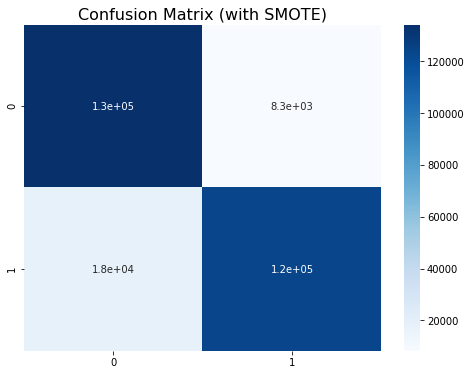

In [61]:
from sklearn.metrics import classification_report,confusion_matrix,roc_curve,roc_auc_score,recall_score

# instantiate RandomForestClassifier
rf_clf1 = RandomForestClassifier(n_estimators=500, max_depth=8, min_samples_split=2, random_state=42)

# fit to the training set
rf_clf1.fit(x_train_sm, y_train_sm)

# predict on the test set
y_pred_rf1 = rf_clf1.predict(X_test_sm)

# check accuracy score
print(accuracy_score(y_pred_rf1, y_test_sm))

print(f'Accuracy = {accuracy_score(y_test_sm, y_pred_rf1):.2f}\nRecall = {recall_score(y_test_sm, y_pred_rf1):.2f}\n')
cm = confusion_matrix(y_test_sm, y_pred_rf1)
plt.figure(figsize=(8, 6))
plt.title('Confusion Matrix (with SMOTE)', size=16)
sns.heatmap(cm, annot=True, cmap='Blues');

#### 3.6.2 XGBoost Classifier<a id='3.6.2_XGBoost_Classifier'></a>

0.8866810089176982
Accuracy = 0.89
Recall = 0.87



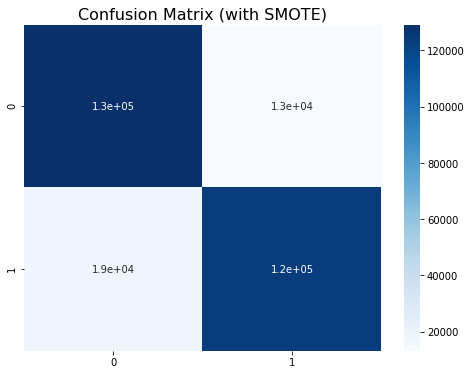

In [62]:
# instantiate the XGBClassifier
xg_boost1 = XGBClassifier(random_state=42, n_estimators=50, learning_rate=0.05)

# fit to the train set
xg_model1 = xg_boost1.fit(x_train_sm, y_train_sm)

# predict on the test set
y_pred_xg1 = xg_model1.predict(X_test_sm)

# check for accuracy
print(accuracy_score(y_pred_xg1, y_test_sm))

print(f'Accuracy = {accuracy_score(y_test_sm, y_pred_xg1):.2f}\nRecall = {recall_score(y_test_sm, y_pred_xg1):.2f}\n')
cm = confusion_matrix(y_test_sm, y_pred_xg1)
plt.figure(figsize=(8, 6))
plt.title('Confusion Matrix (with SMOTE)', size=16)
sns.heatmap(cm, annot=True, cmap='Blues');

#### 3.6.2 Deeplearning with Keras<a id='3.6.2_Deeplearning_with_Keras'></a>

In [63]:
#Design the deep neural network [Small + 2 layers]
model3  = Sequential()
model3.add(Dense(256,input_dim = x_train_sm.shape[1],activation="relu"))
model3.add(Dense(256,activation="relu"))
model3.add(Dense(1,activation = "sigmoid"))
model3.compile(optimizer = "Adam",loss="binary_crossentropy", metrics=["accuracy"])
history = model3.fit(x_train_sm, y_train_sm, validation_data = (x_val_sm,y_val_sm), epochs=10, batch_size=64)

Epoch 1/10
10018/10018 [==============================] - 32s 3ms/step - loss: 0.1723 - accuracy: 0.9345 - val_loss: 0.0971 - val_accuracy: 0.9660
Epoch 2/10
10018/10018 [==============================] - 23s 2ms/step - loss: 0.0864 - accuracy: 0.9702 - val_loss: 0.0708 - val_accuracy: 0.9762
Epoch 3/10
10018/10018 [==============================] - 21s 2ms/step - loss: 0.0674 - accuracy: 0.9773 - val_loss: 0.0674 - val_accuracy: 0.9771
Epoch 4/10
10018/10018 [==============================] - 21s 2ms/step - loss: 0.0588 - accuracy: 0.9804 - val_loss: 0.0594 - val_accuracy: 0.9807
Epoch 5/10
10018/10018 [==============================] - 22s 2ms/step - loss: 0.0508 - accuracy: 0.9834 - val_loss: 0.0560 - val_accuracy: 0.9820
Epoch 6/10
10018/10018 [==============================] - 23s 2ms/step - loss: 0.0466 - accuracy: 0.9849 - val_loss: 0.0547 - val_accuracy: 0.9830
Epoch 7/10
10018/10018 [==============================] - 22s 2ms/step - loss: 0.0428 - accuracy: 0.9860 - val_loss: 0

In [65]:
# evaluate the model on the test set
result = model3.evaluate(X_test_sm,y_test_sm)

for i in range(len(model3.metrics_names)):
    print("Metric ",model3.metrics_names[i],":",str(round(result[i],2)))

8905/8905 [==============================] - 10s 1ms/step - loss: 0.0523 - accuracy: 0.9846
Metric  loss : 0.05
Metric  accuracy : 0.98


### 3.7 Test Data for Submission<a id='3.7_Test Data for Submission'></a>

In [66]:
test_identity = pd.read_csv('/ieee-fraud-detection/test_identity.csv')
test_transaction = pd.read_csv('/ieee-fraud-detection/test_transaction.csv')

In [67]:
# merge transaction and identity datasets
test_data = pd.merge(test_transaction, test_identity, on='TransactionID', how='left')

In [68]:
test_data.columns = [x.replace('-','_') for x in test_data.columns]

In [69]:
test_data = reduce_mem_usage(test_data)

Mem. usage decreased to 2211.13 Mb (0.3% reduction)


In [70]:
# mapping email address to check the percent
# of fraud by email addresses
emails = {'gmail': 'google', 'att.net': 'att', 'twc.com': 'spectrum', 'scranton.edu': 'other', 
          'optonline.net': 'other', 'hotmail.co.uk': 'microsoft', 'comcast.net': 'other', 
          'yahoo.com.mx': 'yahoo', 'yahoo.fr': 'yahoo', 'yahoo.es': 'yahoo', 'charter.net': 
          'spectrum', 'live.com': 'microsoft', 'aim.com': 'aol', 'hotmail.de': 'microsoft', 
          'centurylink.net': 'centurylink', 'gmail.com': 'google', 'me.com': 'apple', 
          'earthlink.net': 'other', 'gmx.de': 'other', 'web.de': 'other', 'cfl.rr.com': 'other', 
          'hotmail.com': 'microsoft', 'protonmail.com': 'other', 'hotmail.fr': 'microsoft', 
          'windstream.net': 'other', 'outlook.es': 'microsoft', 'yahoo.co.jp': 'yahoo', 
          'yahoo.de': 'yahoo', 'servicios-ta.com': 'other', 'netzero.net': 'other', 
          'suddenlink.net': 'other', 'roadrunner.com': 'other', 'sc.rr.com': 'other', 
          'live.fr': 'microsoft', 'verizon.net': 'yahoo', 'msn.com': 'microsoft', 'q.com': 'centurylink', 
          'prodigy.net.mx': 'att', 'frontier.com': 'yahoo', 'anonymous.com': 'other', 
          'rocketmail.com': 'yahoo', 'sbcglobal.net': 'att', 'frontiernet.net': 'yahoo', 
          'ymail.com': 'yahoo', 'outlook.com': 'microsoft', 'mail.com': 'other', 'bellsouth.net': 'other', 
          'embarqmail.com': 'centurylink', 'cableone.net': 'other', 'hotmail.es': 'microsoft',
          'mac.com': 'apple', 'yahoo.co.uk': 'yahoo', 'netzero.com': 'other', 'yahoo.com': 'yahoo', 
          'live.com.mx': 'microsoft', 'ptd.net': 'other', 'cox.net': 'other', 'aol.com': 'aol', 
          'juno.com': 'other', 'icloud.com': 'apple'}
us_emails = ['gmail', 'net', 'edu']

for c in ['P_emaildomain', 'R_emaildomain']:
    test_data[c + '_bin'] = test_data[c].map(emails)
    #df1[c + '_suffix'] = df1[c].map(lambda x: str(x).split('.')[-1])
    #df1[c + '_suffix'] = df1[c + '_suffix'].map(lambda x: x if str(x) not in us_emails else 'us')

In [71]:
# convert TransactionDT to datetime
# was believed the starting date was in 2017
import datetime
startdate = datetime.datetime.strptime('2017-12-01', '%Y-%m-%d')
test_data['TransactionDT'] = test_data['TransactionDT'].apply(lambda x: (startdate + datetime.timedelta(seconds = x)))

In [72]:
# extract year, month, day, hour, minutes and seconds from 'TransactionDT'
test_data['TransactionDT_Month'] = test_data.TransactionDT.dt.month
test_data['TransactionDT_Day'] = test_data.TransactionDT.dt.day
test_data['TransactionDT_Year'] = test_data.TransactionDT.dt.year
test_data['TransactionDT_Week Number'] = test_data.TransactionDT.dt.isocalendar().week 
test_data['TransactionDT_Day Of Week'] = test_data.TransactionDT.dt.dayofweek
test_data['TransactionDT_Day Name']= pd.to_datetime(test_data['TransactionDT']).dt.day_name() 
test_data['TransactionDT_Month Name']=pd.to_datetime(test_data['TransactionDT']).dt.month_name()
test_data['TransactionDT_Hour'] = test_data.TransactionDT.dt.hour
test_data['TransactionDT_Minute'] = test_data.TransactionDT.dt.minute
test_data['TransactionDT_Second'] = test_data.TransactionDT.dt.second

In [73]:
test_data.shape

(506691, 445)

In [74]:
trans_id = test_data['TransactionID']

In [55]:
#cols_1 = ['id-24', 'id-25', 'id-08', 'id-07', 'id-21', 'id-26', 'id-27', 'id-22', 'id-23', 'dist2', 'D7', 'id-18',
            # 'TransactionID', 'TransactionDT', 'P_emaildomain', 'R_emaildomain', 'R_emaildomain_bin', 'DeviceInfo',
                # 'card6']
#test_data = test_data.drop(columns=cols_1, axis=1)

In [75]:
test_col = X_train.columns.tolist()

In [97]:
#test_col

In [76]:
len(test_col)

453

In [149]:
#test_col = test_col[1:]

In [128]:
#test_col.append('TransactionID')

In [35]:
#len(test_col)

In [150]:
#test_df = test_data[test_col]

In [36]:
#len(test_df.columns)

In [77]:
# fillna for numeric columns
test_data.fillna(test_data.select_dtypes(include='number').median().iloc[0], inplace=True)

# fillna for categorical columns
test_data.fillna(test_data.select_dtypes(include='object').mode().iloc[0], inplace=True)

In [78]:
test_df = pd.get_dummies(test_data, drop_first=True)

In [111]:
test_df.shape

(506691, 3454)

In [79]:
test_df = test_df[test_col]

In [80]:
test_df.shape

(506691, 453)

In [81]:
# scale training and test set
scaler = StandardScaler()
scaler.fit(test_df)
test_df_scaled = scaler.transform(test_df)

In [82]:
y_pred = model3.predict(test_df_scaled)

In [83]:
y_pred

array([[1.0000000e+00],
       [9.9596393e-01],
       [9.9868500e-01],
       ...,
       [6.0400464e-05],
       [2.4244189e-04],
       [7.2847921e-01]], dtype=float32)

In [99]:
# Write dataframe to csv
# for submission
submission = pd.DataFrame({"TransactionID":trans_id, "isFraud": y_pred_array})
submission.to_csv('/iee_prediction.csv', index=False)

ValueError: Data must be 1-dimensional

In [186]:
y_pred_proba = xg_model.predict_proba(test_df)[:,1]

In [194]:
y_pred_proba.max()

0.87613463